In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import warnings
warnings.simplefilter('ignore')

In [51]:
data = pd.read_csv('referral.csv', parse_dates = ['date'])
data

,user_id,date,country,money_spent,is_referral,device_id
0,2,2015-10-03,FR,65,0,EVDCJTZMVMJDG
1,3,2015-10-03,CA,54,0,WUBZFTVKXGQQX
2,6,2015-10-03,FR,35,0,CBAPCJRTFNUJG
3,7,2015-10-03,UK,73,0,PRGXJZAJKMXRH
4,7,2015-10-03,MX,35,0,PRGXJZAJKMXRH
...,...,...,...,...,...,...
97336,19934,2015-11-27,UK,35,1,AWMDRMOFTSZIH
97337,19941,2015-11-27,DE,31,1,QAUSDXXLVUERE
97338,19948,2015-11-27,UK,22,1,DCYLHYFLMRODO
97339,19953,2015-11-27,UK,35,1,LROILUYWCNVWQ


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97341 entries, 0 to 97340
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      97341 non-null  int64         
 1   date         97341 non-null  datetime64[ns]
 2   country      97341 non-null  object        
 3   money_spent  97341 non-null  int64         
 4   is_referral  97341 non-null  int64         
 5   device_id    97341 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 4.5+ MB


In [53]:
print('Unique country: ', len(data['country'].unique()))
print('Unique user id: ', len(data['user_id'].unique()))
print('Unique device: ', len(data['device_id'].unique()))

Unique country:  9
Unique user id:  18809
Unique device:  17887


In [54]:
data['dayofweek'] = data['date'].apply(lambda x: x.dayofweek)
start_date = pd.to_datetime('2015-10-31')

# Q1
Can you estimate the impact the program had on the site?

<AxesSubplot:xlabel='date', ylabel='money_spent'>

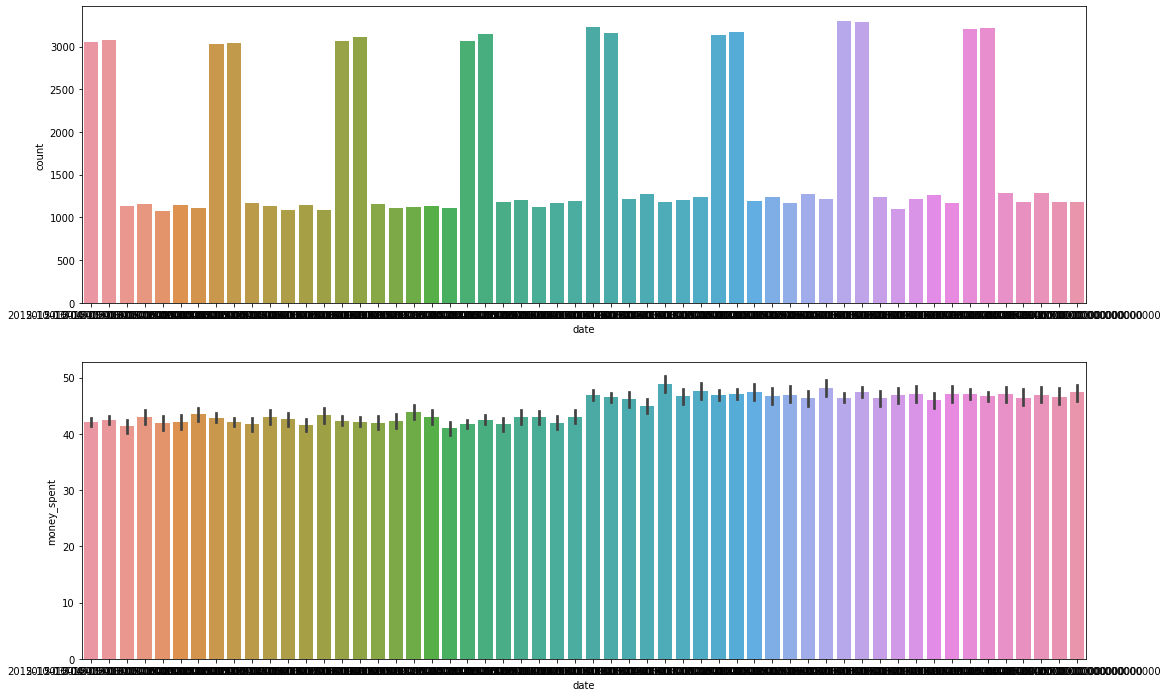

In [55]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
sns.countplot(x = 'date', data = data, ax = ax[0])
sns.barplot(x = 'date', y = 'money_spent', data = data, ax = ax[1])

<AxesSubplot:xlabel='country', ylabel='money_spent'>

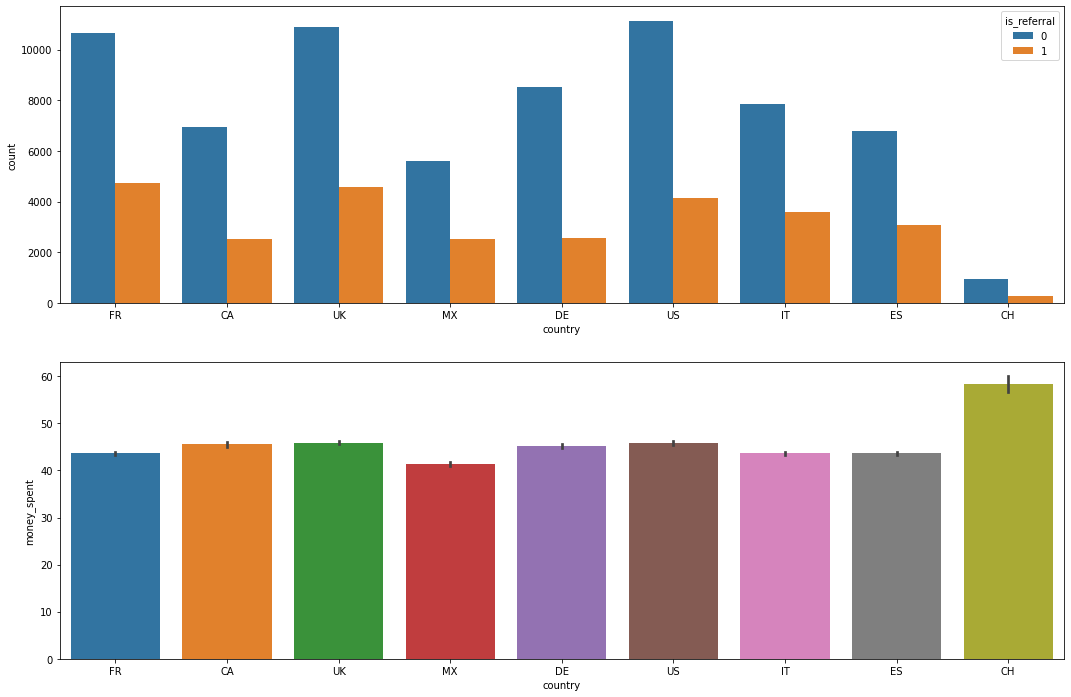

In [56]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
sns.countplot(x='country', hue='is_referral', data=data, ax=ax[0])
sns.barplot(x= 'country', y = 'money_spent', data=data, ax=ax[1])

<AxesSubplot:xlabel='dayofweek', ylabel='money_spent'>

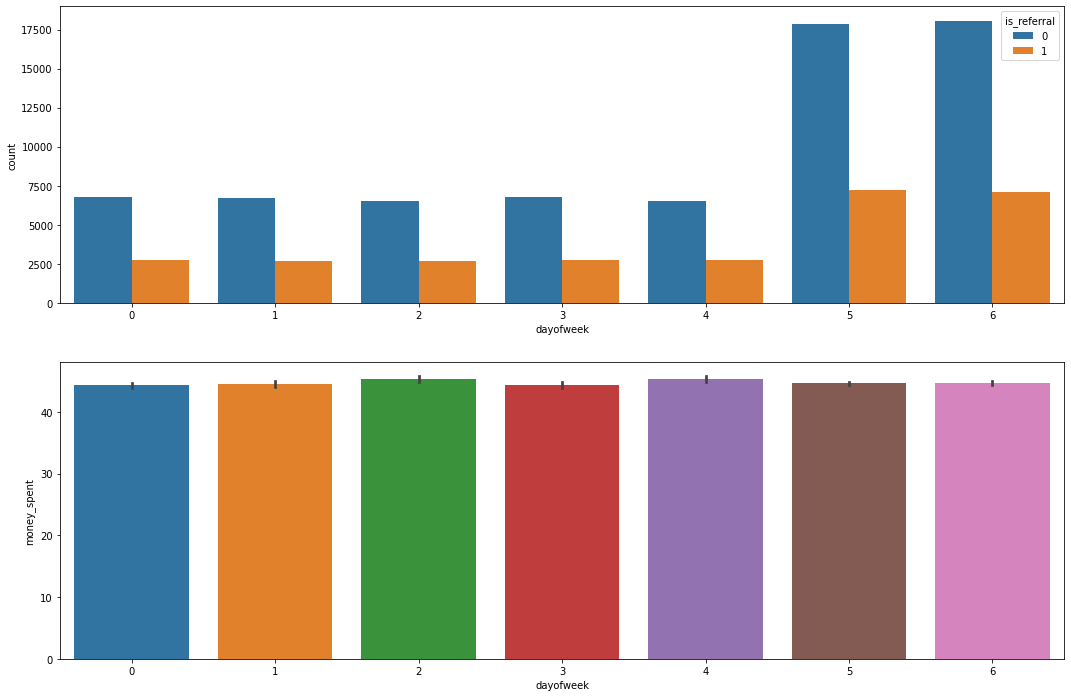

In [57]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
sns.countplot(x='dayofweek', hue='is_referral', data=data, ax=ax[0])
sns.barplot(x= 'dayofweek', y = 'money_spent', data=data, ax=ax[1])

From the visualization above diagram 1 and 2, the money spent across every day within this dataset is almost equal everyday with no obvious increase after referral program.

However, the visualization of the diagram 3 and 4, the users in Chinese region has the least amont of users across 9 countries, and it has the highest money spent. 


# Q2:
Based on the data, what would you suggest to do as a next step?

I suggest perform more accurate A/B test (see question 3's answer) and collect more data, to study the impact of the program
since the program has different impact in different country, I suggest studying the reason of such difference. for example, does the program has any cultural conflicts in CH and DE?

# Q3
The referral program wasn't really tested in a rigorous way. It simply started on a given
day for all users and you are drawing conclusions by looking at the data before and after
the test started. What kinds of risks this approach presents? Can you think of a better
way to test the referral program and measure its impact?

In [102]:
def basic_stat(df):
    num_purchase = len(df)
    money_spent = df['money_spent'].sum()
    unique_user = len(df['user_id'].unique())
    return pd.Series([num_purchase, money_spent, unique_user], 
                     index=['num_purchase', 'money_spent', 'unique_user'])

In [107]:
def abtest(df):
    refer = df.groupby('date').apply(basic_stat).reset_index()
    before = refer[refer['date'] < start_date]
    after = refer[refer['date'] >= start_date]

    columns = ['num_purchase', 'money_spent', 'unique_user']
    result = []
    for c in columns:
        mean_bef = before[c].mean()
        mean_aft = after[c].mean()
        control = before[c]
        experiment = after[c]
        p_value = ttest_ind(control , experiment)[1] / 2
        result.append({'mean_bef':mean_bef,'mean_aft':mean_aft,'mean_diff':mean_aft - mean_bef, 
                       'percent_change': (mean_aft - mean_bef) /mean_bef * 100, 'pvalue':p_value})
    return pd.DataFrame(result,index = columns)

In [108]:
abtest(data)

,mean_bef,mean_aft,mean_diff,percent_change,pvalue
num_purchase,1690.750000,1785.714286,94.964286,5.616696,0.348256
money_spent,71657.000000,83714.392857,12057.392857,16.826539,0.135149
unique_user,1384.464286,1686.964286,302.500000,21.849607,0.059242


In [109]:
data.groupby('country').apply(abtest)

mean_bef      mean_aft    mean_diff  percent_change  \
country                                                                         
CA      num_purchase    177.142857    160.000000   -17.142857       -9.677419   
        money_spent    7468.428571   7880.428571   412.000000        5.516555   
        unique_user     173.285714    159.178571   -14.107143       -8.140973   
CH      num_purchase     26.821429     17.071429    -9.750000      -36.351531   
        money_spent    1536.321429   1023.892857  -512.428571      -33.354255   
        unique_user      26.714286     17.071429    -9.642857      -36.096257   
DE      num_purchase    232.142857    164.035714   -68.107143      -29.338462   
        money_spent    9856.750000   8013.964286 -1842.785714      -18.695673   
        unique_user     224.964286    163.250000   -61.714286      -27.432926   
ES      num_purchase    156.607143    194.500000    37.892857       24.196123   
        money_spent    6648.642857   8660.571429  2011.928571       30.260741   
        unique_user     153.392857    193.214286    39.821429       25.960419   
FR      num_purchase    244.142857    305.714286    61.571429       25.219427   
        money_spent   10385.250000  13635.000000  3249.750000       31.291977   
        unique_user     236.500000    302.535714    66.035714       27.922078   
IT      num_purchase    180.857143    227.928571    47.071429       26.026856   
        money_spent    7651.571429  10193.428571  2541.857143       33.220067   
        unique_user     176.535714    226.107143    49.571429       28.080113   
MX      num_purchase    126.464286    164.000000    37.535714       29.680881   
        money_spent    4975.464286   7033.214286  2057.750000       41.357949   
        unique_user     124.392857    163.107143    38.714286       31.122595   
UK      num_purchase    264.285714    289.035714    24.750000        9.364865   
        money_spent   11213.535714  14196.428571  2982.892857       26.600824   
        unique_user     255.571429    286.321429    30.750000       12.031861   
US      num_purchase    282.285714    263.428571   -18.857143       -6.680162   
        money_spent   11921.035714  13077.464286  1156.428571        9.700739   
        unique_user     273.178571    261.107143   -12.071429       -4.418878   

                        pvalue  
country                         
CA      num_purchase  0.233965  
        money_spent   0.351700  
        unique_user   0.268249  
CH      num_purchase  0.002971  
        money_spent   0.006818  
        unique_user   0.003046  
DE      num_purchase  0.011541  
        money_spent   0.081313  
        unique_user   0.015440  
ES      num_purchase  0.072557  
        money_spent   0.037422  
        unique_user   0.057836  
FR      num_purchase  0.058880  
        money_spent   0.031688  
        unique_user   0.040959  
IT      num_purchase  0.057303  
        money_spent   0.025526  
        unique_user   0.043720  
MX      num_purchase  0.032346  
        money_spent   0.009471  
        unique_user   0.026105  
UK      num_purchase  0.261181  
        money_spent   0.048423  
        unique_user   0.204385  
US      num_purchase  0.307800  
        money_spent   0.248854  
        unique_user   0.368860

In [111]:
data.groupby('dayofweek').apply(abtest)

mean_bef   mean_aft  mean_diff  percent_change  \
dayofweek                                                                 
0         num_purchase    1159.75    1233.50      73.75        6.359129   
          money_spent    48356.50   57677.00    9320.50       19.274555   
          unique_user     1036.75    1190.25     153.50       14.805884   
1         num_purchase    1152.75    1200.50      47.75        4.142268   
          money_spent    49333.00   55473.25    6140.25       12.446537   
          unique_user     1026.50    1168.00     141.50       13.784705   
2         num_purchase    1104.00    1209.50     105.50        9.556159   
          money_spent    47302.00   57406.75   10104.75       21.362205   
          unique_user      987.50    1174.75     187.25       18.962025   
3         num_purchase    1148.75    1229.00      80.25        6.985854   
          money_spent    48445.00   57043.25    8598.25       17.748478   
          unique_user     1036.25    1190.25     154.00       14.861279   
4         num_purchase    1123.50    1200.50      77.00        6.853583   
          money_spent    48019.75   57138.50    9118.75       18.989582   
          unique_user     1014.25    1167.75     153.50       15.134336   
5         num_purchase    3052.00    3219.75     167.75        5.496396   
          money_spent   129109.25  150779.25   21670.00       16.784235   
          unique_user     2280.50    2967.75     687.25       30.135935   
6         num_purchase    3094.50    3207.25     112.75        3.643561   
          money_spent   131033.50  150482.75   19449.25       14.842960   
          unique_user     2309.50    2950.00     640.50       27.733276   

                              pvalue  
dayofweek                             
0         num_purchase  7.457807e-03  
          money_spent   7.506359e-05  
          unique_user   2.685038e-05  
1         num_purchase  1.487689e-01  
          money_spent   5.809467e-03  
          unique_user   5.134295e-03  
2         num_purchase  6.108105e-03  
          money_spent   2.716765e-04  
          unique_user   2.548403e-04  
3         num_purchase  8.617253e-03  
          money_spent   5.738730e-05  
          unique_user   4.377574e-04  
4         num_purchase  1.494875e-02  
          money_spent   5.033619e-04  
          unique_user   5.598869e-04  
5         num_purchase  1.779080e-03  
          money_spent   2.508669e-06  
          unique_user   4.651264e-07  
6         num_purchase  1.111767e-02  
          money_spent   5.810154e-05  
          unique_user   5.721376e-07

We cannot say the referral program has a positive effect as whole, since the p-value for all the stats('num_purchase', 'money_spent', 'unique_user) >0.05.


However, splitting up by country, after the referral program, we could observe that huge negative effect on CN and DE with a p-value < 0.05.

And as for the positive effect ES, FR, IT, MX with a p-value around 0.05

Last, but not least, not a huge effect on CA, US and UK

One thing to notice here is that Oct 31st is approaching some holidays in the Western Coutries, we should conduct more rigorous A/B test,

1. during the same peroid of time
2. randomly split the customers into two groups, and let only one group know the User Referral program.
3. run the experiment some time, then perform the t-test to see whether some 'sale performance index' (e.g., daily spent, daily customers, daily transactions) have significant changes or not.

reference: https://github.com/stasi009/TakeHomeDataChallenges/blob/master/11.UserReferral/user_referral.ipynb